In [3]:
# materials: stack
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
np.float_ = np.float64
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from IPython.display import display
import pickle

data = pd.read_parquet('data/raw/data_v1.parquet')

ADF Statistic: 0.4823236847014844
p-value: 0.9843258203818094
A série não é estacionária. Considere diferenciação ou transformação.


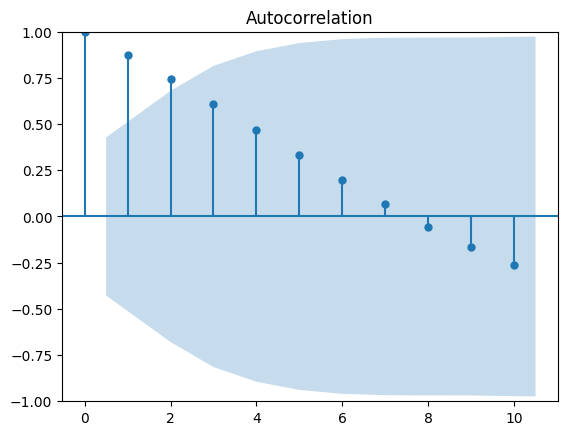

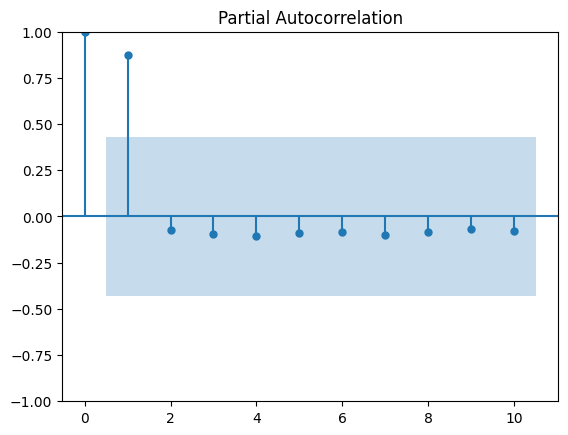

ADF Statistic: -10.15701119623911
p-value: 7.682328750230447e-18
A série é estacionária


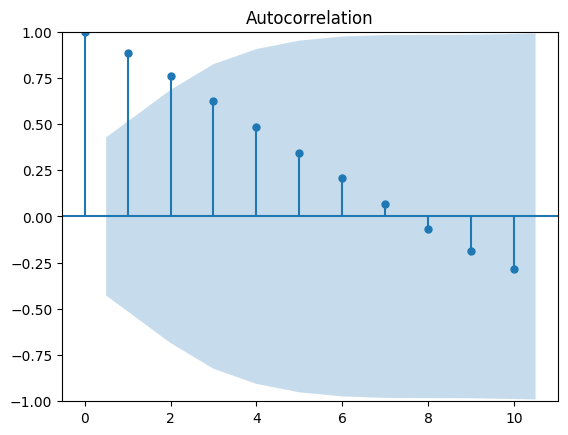

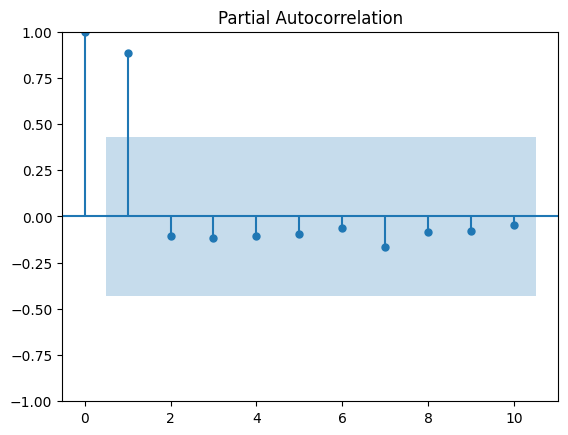

In [4]:
# 1. Avaliação dos Pressupostos
def evaluate_assumptions(data, variable):
    # Verificando a estacionariedade com o teste de Dickey-Fuller Aumentado
    result = adfuller(data[f'{variable}'])
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    if result[1] < 0.05:
        print("A série é estacionária")
    else:
        print("A série não é estacionária. Considere diferenciação ou transformação.")

    # Plotando ACF e PACF para avaliar autocorrelação
    plot_acf(data[f'{variable}'])
    plt.show()
    plot_pacf(data[f'{variable}'])
    plt.show()

evaluate_assumptions(data, 'ig_maus')
evaluate_assumptions(data, 'tk_maus')

19:22:10 - cmdstanpy - INFO - Chain [1] start processing
19:22:19 - cmdstanpy - INFO - Chain [1] done processing


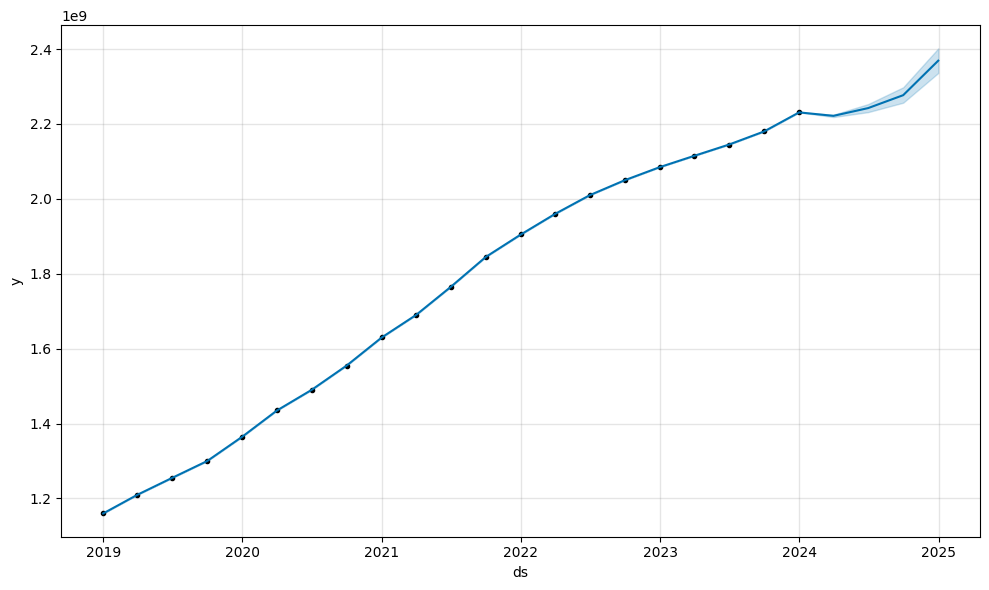

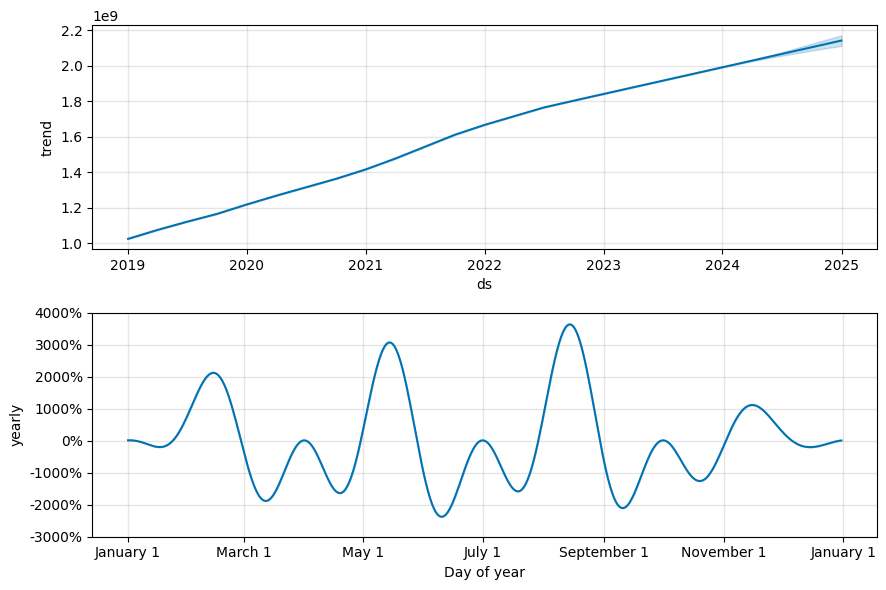

19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing


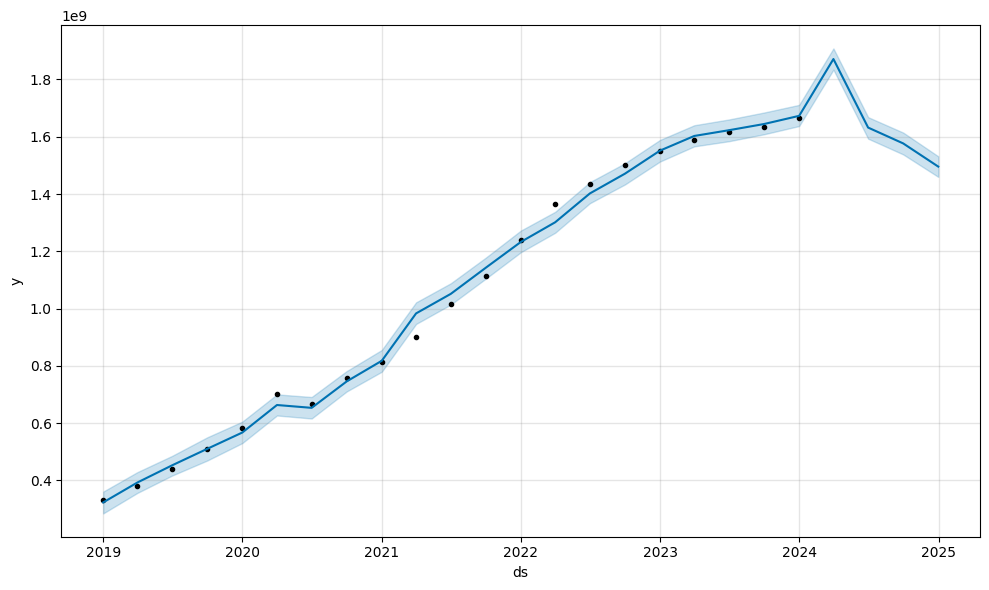

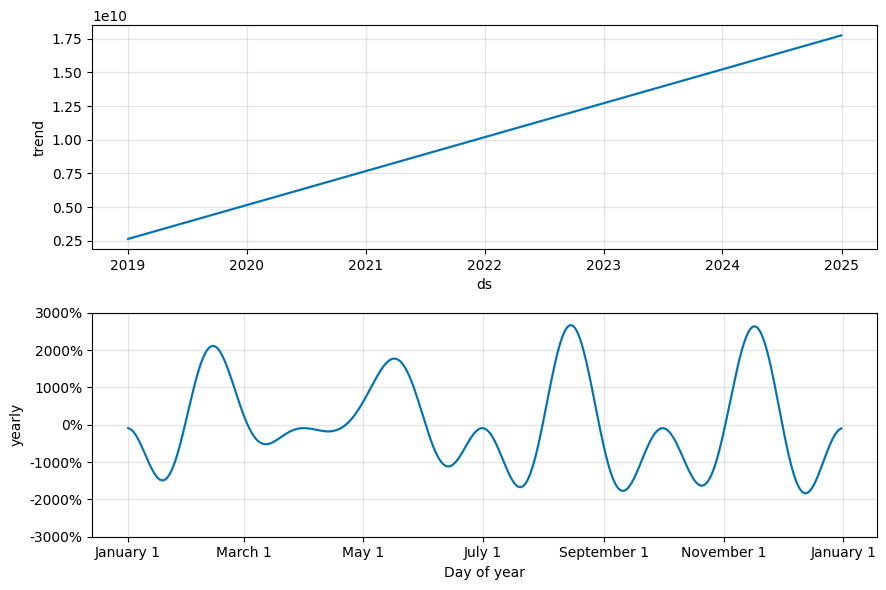

In [5]:
# 2. Modelagem e Treino
def fit_preditct_prophet(data, variable):
    # Definindo a semente para reprodução de resultados
    np.random.seed(42)

    # Prophet requer colunas específicas: 'ds' para a data e 'y' para o valor a ser previsto
    df_prophet = data.rename(columns={'quarter': 'ds', f'{variable}': 'y'})
    
    # Inicializando e ajustando o modelo Prophet
    model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
    model.fit(df_prophet)
    
    # Criando um dataframe de datas futuras para prever
    future = model.make_future_dataframe(periods=4, freq='QE')
    forecast = model.predict(future)
    
    # Plotando a previsão
    model.plot(forecast)
    plt.show()
    
    # Plotando componentes da tendência e sazonalidade
    model.plot_components(forecast)
    plt.show()

    return forecast, model

# 2. Treinamento do modelo Prophet
ig_maus_forecast_prophet_model_v1, ig_maus_prophet_model_v1 = fit_preditct_prophet(data, 'ig_maus')
tk_maus_forecast_prophet_model_v1, tk_maus_prophet_model_v1 = fit_preditct_prophet(data, 'tk_maus')

RMSE: 31515.01470896139
MAE: 27638.7529814811
RMSE é menor que a média dos dados. O modelo parece ser bom.
MAE é menor que a média dos dados. O modelo parece ser bom.


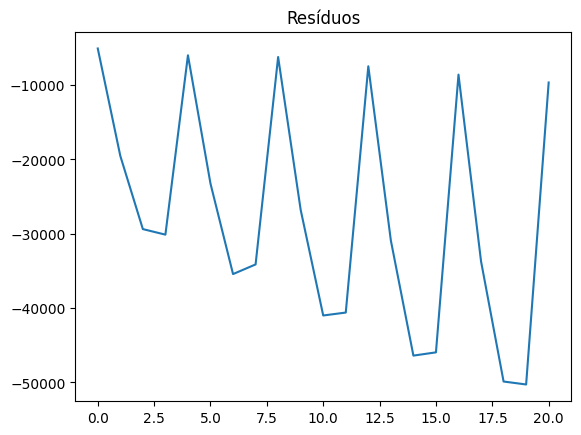

RMSE: 29140462.832071505
MAE: 21105853.83430639
RMSE é menor que a média dos dados. O modelo parece ser bom.
MAE é menor que a média dos dados. O modelo parece ser bom.


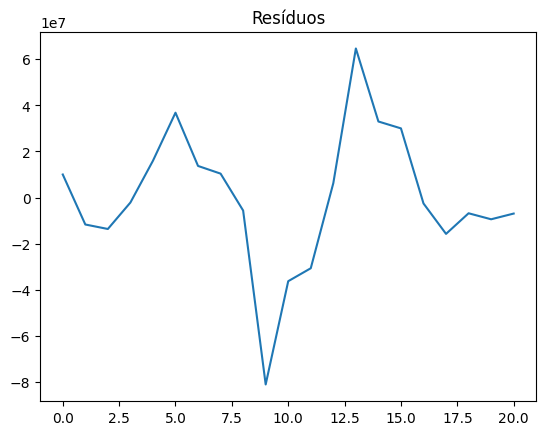

(np.float64(29140462.832071505), np.float64(21105853.83430639))

In [6]:
# 3. Avaliação do Modelo
def evaluate_model(actual, forecast):
    # Extraindo as previsões de MAUs
    predicted = forecast['yhat'].iloc[:len(actual)]
    
    # Calculando RMSE e MAE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    if rmse < actual.mean():
        print('RMSE é menor que a média dos dados. O modelo parece ser bom.')
    else:
        print('RMSE é maior que a média dos dados. O modelo parece ser ruim.')

    if mae < actual.mean():
        print('MAE é menor que a média dos dados. O modelo parece ser bom.')
    else:
        print('MAE é maior que a média dos dados. O modelo parece ser ruim.')
    
    # Plotando resíduos
    residuals = actual - predicted
    plt.plot(residuals)
    plt.title('Resíduos')
    plt.show()

    return rmse, mae
evaluate_model(data['ig_maus'], ig_maus_forecast_prophet_model_v1)
evaluate_model(data['tk_maus'], tk_maus_forecast_prophet_model_v1)

In [7]:
# Salva o modelo treinado
with open('models/ig_maus_prophet_model_v1', 'wb') as f:
    pickle.dump(ig_maus_prophet_model_v1, f)

with open('models/tk_maus_prophet_model_v1', 'wb') as f:
    pickle.dump(tk_maus_prophet_model_v1, f)